In [20]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm
from tqdm import tqdm
import torch
import copy
from scipy.stats import kurtosis

# Generate returns

In [16]:
# 1 pool example

N_pools = 1
params = {'N_pools': N_pools,
          'Rx0': 100 * np.ones(N_pools),
          'Ry0': 1000 * np.ones(N_pools),
          'phi': np.array([0.03]),
          'x_0': 10,
          'alpha': 0.05,
          'q': 0.85,
          'zeta': 0.05,
          'batch_size': 1_000,
          'kappa': np.array([1., 1.]),
          'sigma': np.array([1., 1.]),
          'p': np.array([0.3, 0.3]),
          'T': 10,
          'seed': 4294967143}

In [44]:
log_rets = []

d = {
    'phi': np.linspace(-0.02, 0.02, 5),
    'sigma': np.linspace(-0.5, 0.5, 5),
    'kappa': np.linspace(-0.5, 0.5, 5),
    'p': np.linspace(-0.05, 0.05, 5),
    'x_0': np.array([-5., 0., 5., 10., 20., 50., 100., 200.]),
}

results = dict()

for param, diffs in d.items():
    results[param] = {'diffs': diffs, 'output': []}
    for diff in diffs:
        new_params = copy.deepcopy(params)
        new_params[param] += diff

        # put them into global scope, so that we can call e.g. kappa, instead of params['kappa']
        locals().update(new_params)
        
        pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)
        
        xs_0 = np.repeat(x_0, N_pools)
        l = pools.swap_and_mint(xs_0)
        
        np.random.seed(seed)
        end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)
        
        x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
        log_ret = np.log(x_T) - np.log(x_0)
        log_ret = log_ret[:, 0]

        results[param]['output'] += [{'log_ret': log_ret, 'label': f"{param} += {diff:.3f}"}]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1046.30it/s]


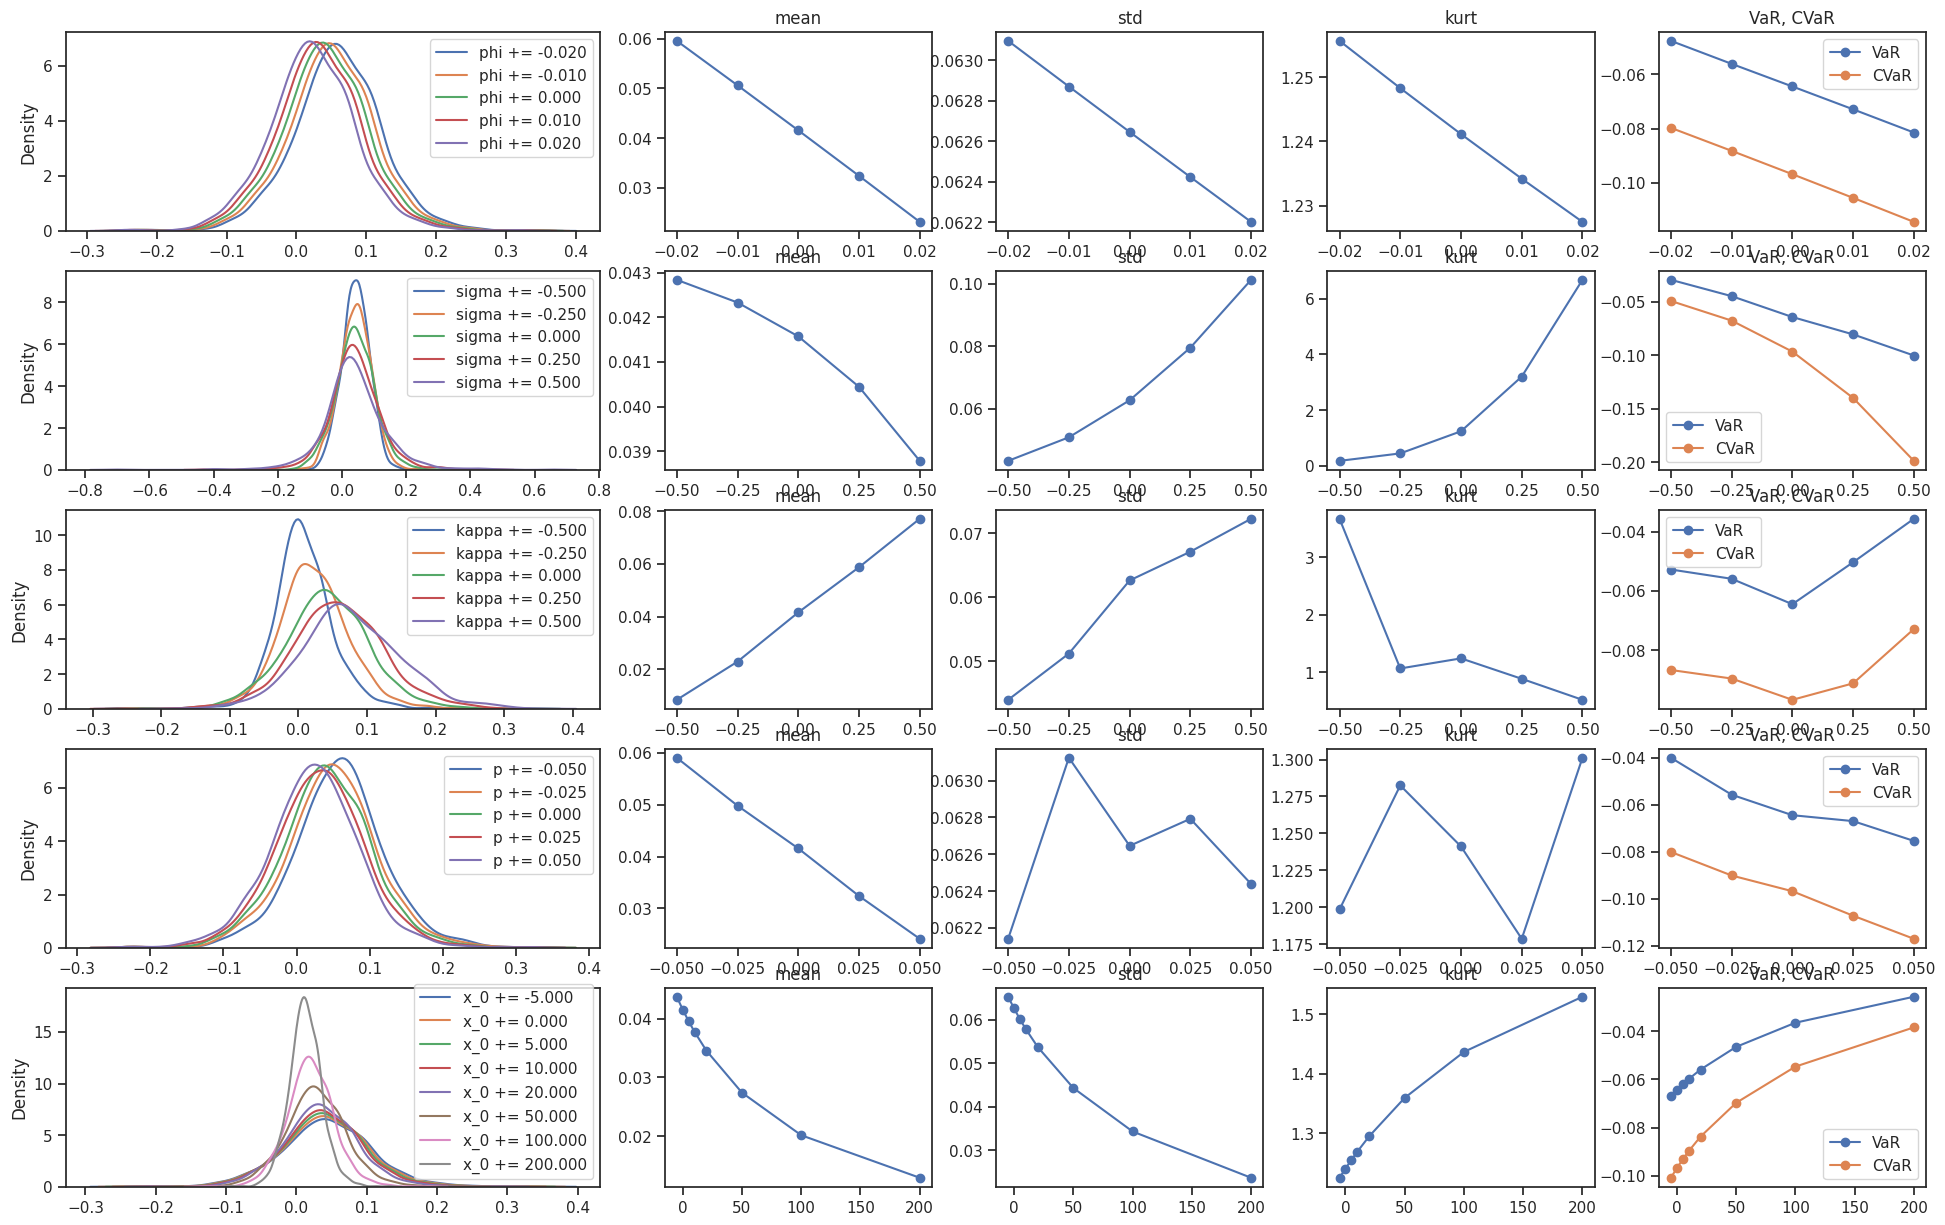

In [57]:
fig, ax = plt.subplots(figsize=(24, 3 * len(d)), nrows=len(d), ncols=5, gridspec_kw={'width_ratios': [2, 1, 1, 1, 1]})

for i, (param, result) in enumerate(results.items()):
    
    for run in result['output']:
        sns.kdeplot(run['log_ret'], ax=ax[i][0], label=run['label'])
    ax[i][0].legend()
    
    means = np.array([np.mean(run['log_ret']) for run in result['output']])
    ax[i][1].plot(result['diffs'], means, marker='o')
    ax[i][1].set_title('mean')
    
    stds = np.array([np.std(run['log_ret']) for run in result['output']])
    ax[i][2].plot(result['diffs'], stds, marker='o')
    ax[i][2].set_title('std')

    kurts = np.array([kurtosis(run['log_ret']) for run in result['output']])
    ax[i][3].plot(result['diffs'], kurts, marker='o')
    ax[i][3].set_title('kurt')

    vars = np.array([np.quantile(run['log_ret'], alpha) for run in result['output']])
    cvars = np.array([np.sum(run['log_ret'] * (run['log_ret'] <= np.quantile(run['log_ret'], alpha))) / np.sum(run['log_ret'] <= np.quantile(run['log_ret'], alpha)) / (1 - alpha) for run in result['output']])
    ax[i][4].plot(result['diffs'], vars, marker='o', label='VaR')
    ax[i][4].plot(result['diffs'], cvars, marker='o', label='CVaR')
    ax[i][4].legend()
    ax[i][4].set_title('VaR, CVaR')

fig.savefig('_output/pool_analysis.png')